# Direct PSF subtraction flux comparison
Compare fitted and catalog fluxes for all "good" sources. The goal in this notebook to demonstrate that the PSF at the source centroid positions reasonably describe point sources. We fit a numerical scaling factor to the PSF and subtract from the image stamp.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.geom as geom
from astropy.visualization import ZScaleInterval

%run -n -i "subtraction_defs.py"

In [2]:
# ProcessCcd w/psfex repo
REPO = '/data1/gkovacs/DM-27127-repo/ingested/rerun/pccd_psfex'
butler = dafPersist.Butler(REPO)
dataId={'visit': 419802, 'ccdnum':25}

calexp = butler.get('calexp', dataId=dataId)
srcCat = butler.get('src', dataId=dataId)

In [3]:
# This is the condition R.Lupton used in his example
# "not a blend" and "sdss centroid is valid"
i_goodSrc = (srcCat["deblend_nChild"] == 0) & (~srcCat["base_SdssCentroid_flag"])
# Alternative selection
# i_goodSrc = srcCat['calib_psf_used']

-------

### Get the fluxes
We fit a multiplicative factor to the PSF. The PSF is normalized to 1, so this factor is the source flux.

In [4]:
fluxes = []
calib = calexp.getPhotoCalib()
for src in srcCat[i_goodSrc]:
    res = getCutoutAndPsf(calexp, src)
    resD = minimizeDiff(res.cutExp, res.psfIm)
    fluxes.append(calib.instFluxToNanojansky(resD.x))
fluxes = np.array(fluxes)

In [5]:
cat2 = srcCat[i_goodSrc]
# _instFlux is automatically appended to column name
# catfluxes = calib.instFluxToNanojansky(cat2,'base_GaussianFlux')[:, 0]
catfluxes = calib.instFluxToNanojansky(cat2,'base_SdssShape')[:, 0]

In [6]:
flt = np.isfinite(catfluxes)

<IPython.core.display.Javascript object>


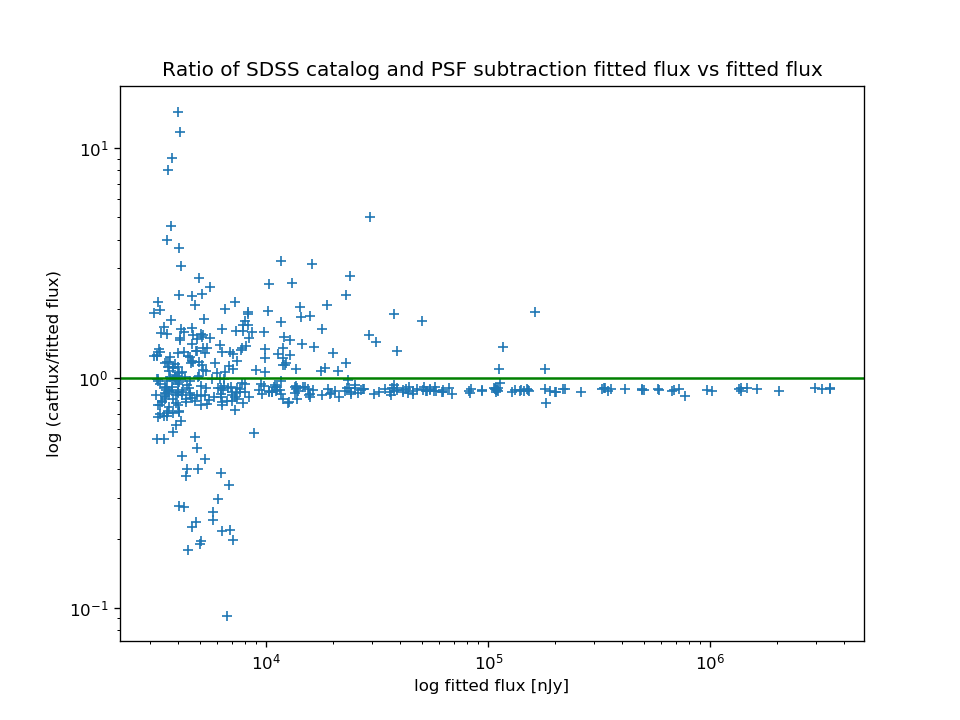

Text(0.5, 1.0, 'Ratio of SDSS catalog and PSF subtraction fitted flux vs fitted flux')

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(fluxes[flt], catfluxes[flt] / fluxes[flt], '+', label='pca')
ax.axhline(1, c='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('log fitted flux [nJy]')
ax.set_ylabel('log (catflux/fitted flux)')
ax.set_title("Ratio of SDSS catalog and PSF subtraction fitted flux vs fitted flux")

<IPython.core.display.Javascript object>


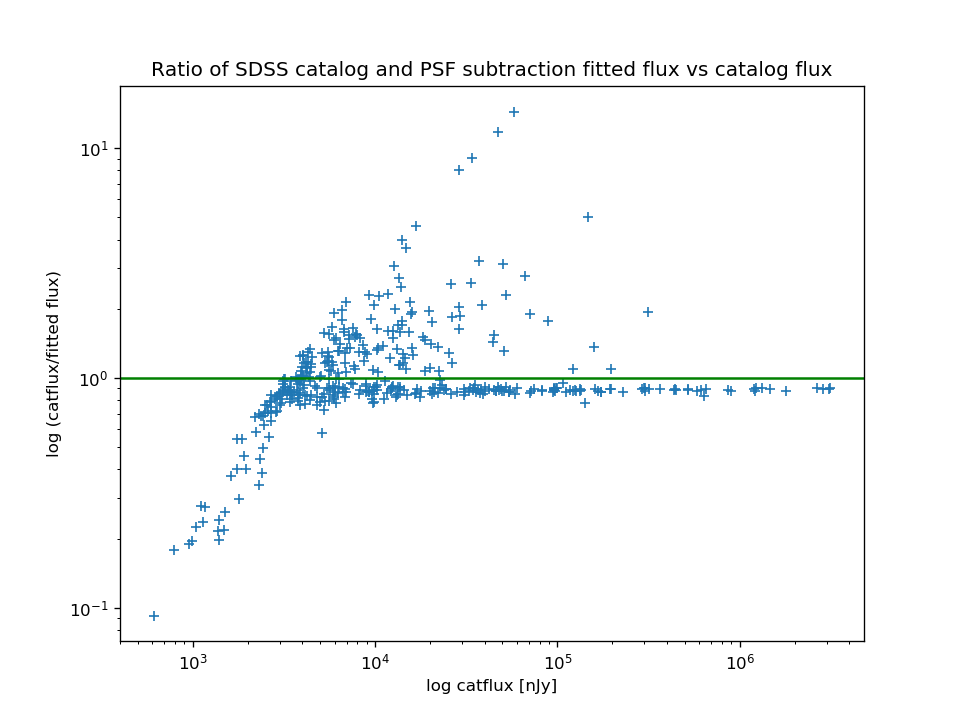

Text(0.5, 1.0, 'Ratio of SDSS catalog and PSF subtraction fitted flux vs catalog flux')

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(catfluxes[flt], catfluxes[flt] / fluxes[flt], '+', label='pca')
ax.axhline(1, c='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('log catflux [nJy]')
ax.set_ylabel('log (catflux/fitted flux)')
ax.set_title("Ratio of SDSS catalog and PSF subtraction fitted flux vs catalog flux")

 * The horizontal line: agreement with the catalog. The line is at ~ 0.9, it's a systematic between our method and the catalog how the _total_ flux is calculated.
 * Not shown, but both the catalog and our fitting have increasing errors towards the faint end.
 * The sdss catalog goes fainter. At the faint end the decam image source flux disappears in the noise and matched to fainter or brighter sdss sources. Hence the vertical line in the upper panel, diagonal in the lower panel.
 
 